In [ ]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTree

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
df_weather = pd.read_csv('/content/drive/MyDrive/cis9660_data/finalproject_dataset.csv')

In [ ]:
df_weather.head()

,Unnamed: 0,YEAR,MONTH,DAY,AWND(metres/sec),PRCP(cm),SNOW(cm),SNWD(cm),TMAX(celsius),TMIN(celsius),WDF2(degrees),WDF5(degrees),WSF2(metres/sec),WSF5(metres/sec),DailyDewPointTemperature(celsius),DailyDryBulbTemperature(celsius),DailyPrecipitation(cm)(Hourlymean),DailyRelativeHumidity,DailySeaLevelPressure(inches),DailyStationPressure(inches),DailyVisibility,DailyWetBulbTemperature(celsius),DailyWindSpeed(miles/hr)
0,0,2011,5,2,2.80,0.00,0.0,0.0,16.65,10.00,150.0,165.0,5.85,8.30,6.471193,12.453704,0.000000,68.027778,30.221574,30.138621,9.993333,9.779693,6.472222
1,1,2011,5,3,3.60,0.00,0.0,0.0,22.80,11.95,275.0,215.0,7.15,9.80,10.305305,14.671717,0.000000,76.054545,30.069619,29.962545,9.831892,13.343434,8.954955
2,2,2011,5,4,3.85,1.27,0.0,0.0,17.50,8.05,300.0,305.0,8.05,10.95,9.202509,11.645646,7.717692,85.686486,29.954112,29.865938,7.322043,10.028935,9.274194
3,3,2011,5,5,5.25,0.00,0.0,0.0,17.75,8.05,290.0,310.0,10.70,14.30,1.293019,12.227096,0.338667,52.884956,29.922075,29.860833,9.634386,7.024482,11.842105
4,4,2011,5,6,3.80,0.00,0.0,0.0,21.40,10.55,175.0,175.0,8.30,11.40,3.405350,15.102881,0.000000,48.027778,29.926916,29.839661,9.993333,9.416196,9.092593


In [ ]:
# change any non-zero values to 1 to signify preciptation occurred
df_weather['PRCP(cm)'].loc[df_weather['PRCP(cm)'] > 0] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_weather

,Unnamed: 0,YEAR,MONTH,DAY,AWND(metres/sec),PRCP(cm),SNOW(cm),SNWD(cm),TMAX(celsius),TMIN(celsius),WDF2(degrees),WDF5(degrees),WSF2(metres/sec),WSF5(metres/sec),DailyDewPointTemperature(celsius),DailyDryBulbTemperature(celsius),DailyPrecipitation(cm)(Hourlymean),DailyRelativeHumidity,DailySeaLevelPressure(inches),DailyStationPressure(inches),DailyVisibility,DailyWetBulbTemperature(celsius),DailyWindSpeed(miles/hr)
0,0,2011,5,2,2.80,0.0,0.0,0.0,16.65,10.00,150.0,165.0,5.85,8.30,6.471193,12.453704,0.000000,68.027778,30.221574,30.138621,9.993333,9.779693,6.472222
1,1,2011,5,3,3.60,0.0,0.0,0.0,22.80,11.95,275.0,215.0,7.15,9.80,10.305305,14.671717,0.000000,76.054545,30.069619,29.962545,9.831892,13.343434,8.954955
2,2,2011,5,4,3.85,1.0,0.0,0.0,17.50,8.05,300.0,305.0,8.05,10.95,9.202509,11.645646,7.717692,85.686486,29.954112,29.865938,7.322043,10.028935,9.274194
3,3,2011,5,5,5.25,0.0,0.0,0.0,17.75,8.05,290.0,310.0,10.70,14.30,1.293019,12.227096,0.338667,52.884956,29.922075,29.860833,9.634386,7.024482,11.842105
4,4,2011,5,6,3.80,0.0,0.0,0.0,21.40,10.55,175.0,175.0,8.30,11.40,3.405350,15.102881,0.000000,48.027778,29.926916,29.839661,9.993333,9.416196,9.092593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3636,3636,2021,4,15,3.25,1.0,0.0,0.0,14.70,7.20,325.0,295.0,7.85,11.40,8.237179,10.929487,9.786471,83.875000,29.721786,29.633269,6.639904,9.556624,6.851485
3637,3637,2021,4,16,4.40,1.0,0.0,0.0,11.70,5.30,255.0,255.0,9.20,14.10,2.129630,7.793210,0.390769,68.736111,29.651250,29.571528,9.743333,5.246914,9.333333
3638,3638,2021,4,17,3.15,0.0,0.0,0.0,13.05,6.40,275.0,275.0,6.25,8.75,1.345486,9.487847,0.000000,58.609375,29.765714,29.675937,9.992500,5.824653,7.063492
3639,3639,2021,4,18,2.50,0.0,0.0,0.0,17.50,9.70,200.0,205.0,5.60,7.85,2.609127,13.095238,0.000000,50.196429,29.822679,29.744643,9.991429,8.154762,5.803571


In [ ]:
# Date column

df_weather = df_weather[['Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'AWND(metres/sec)', 'PRCP(cm)',
       'SNOW(cm)', 'SNWD(cm)', 'TMAX(celsius)', 'TMIN(celsius)',
       'WDF2(degrees)', 'WDF5(degrees)', 'WSF2(metres/sec)',
       'WSF5(metres/sec)', 'DailyDewPointTemperature(celsius)',
       'DailyDryBulbTemperature(celsius)',
       'DailyPrecipitation(cm)(Hourlymean)', 'DailyRelativeHumidity',
       'DailySeaLevelPressure(inches)', 'DailyStationPressure(inches)',
       'DailyVisibility', 'DailyWetBulbTemperature(celsius)',
       'DailyWindSpeed(miles/hr)']]
# create DATE column
df_weather['DATE'] = pd.to_datetime(df_weather.YEAR*10000+df_weather.MONTH*100+df_weather.DAY, format='%Y%m%d')

In [ ]:
# add future days to the dataframe
fdates = pd.DataFrame(
    pd.date_range(
        df_weather['DATE'].min(),
        df_weather['DATE'].max() + pd.DateOffset(days=1)
    ),
    columns=['future_dates'])

df_weather = fdates.merge(df_weather, left_on='future_dates', right_on='DATE', how='left')
df_weather = df_weather.drop(columns=['DATE', 'Unnamed: 0'])
df_weather = df_weather.rename(columns={'future_dates': 'DATE'})
df_weather

,DATE,YEAR,MONTH,DAY,AWND(metres/sec),PRCP(cm),SNOW(cm),SNWD(cm),TMAX(celsius),TMIN(celsius),WDF2(degrees),WDF5(degrees),WSF2(metres/sec),WSF5(metres/sec),DailyDewPointTemperature(celsius),DailyDryBulbTemperature(celsius),DailyPrecipitation(cm)(Hourlymean),DailyRelativeHumidity,DailySeaLevelPressure(inches),DailyStationPressure(inches),DailyVisibility,DailyWetBulbTemperature(celsius),DailyWindSpeed(miles/hr)
0,2011-05-02,2011.0,5.0,2.0,2.80,0.0,0.0,0.0,16.65,10.00,150.0,165.0,5.85,8.30,6.471193,12.453704,0.000000,68.027778,30.221574,30.138621,9.993333,9.779693,6.472222
1,2011-05-03,2011.0,5.0,3.0,3.60,0.0,0.0,0.0,22.80,11.95,275.0,215.0,7.15,9.80,10.305305,14.671717,0.000000,76.054545,30.069619,29.962545,9.831892,13.343434,8.954955
2,2011-05-04,2011.0,5.0,4.0,3.85,1.0,0.0,0.0,17.50,8.05,300.0,305.0,8.05,10.95,9.202509,11.645646,7.717692,85.686486,29.954112,29.865938,7.322043,10.028935,9.274194
3,2011-05-05,2011.0,5.0,5.0,5.25,0.0,0.0,0.0,17.75,8.05,290.0,310.0,10.70,14.30,1.293019,12.227096,0.338667,52.884956,29.922075,29.860833,9.634386,7.024482,11.842105
4,2011-05-06,2011.0,5.0,6.0,3.80,0.0,0.0,0.0,21.40,10.55,175.0,175.0,8.30,11.40,3.405350,15.102881,0.000000,48.027778,29.926916,29.839661,9.993333,9.416196,9.092593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,2021-04-16,2021.0,4.0,16.0,4.40,1.0,0.0,0.0,11.70,5.30,255.0,255.0,9.20,14.10,2.129630,7.793210,0.390769,68.736111,29.651250,29.571528,9.743333,5.246914,9.333333
3638,2021-04-17,2021.0,4.0,17.0,3.15,0.0,0.0,0.0,13.05,6.40,275.0,275.0,6.25,8.75,1.345486,9.487847,0.000000,58.609375,29.765714,29.675937,9.992500,5.824653,7.063492
3639,2021-04-18,2021.0,4.0,18.0,2.50,0.0,0.0,0.0,17.50,9.70,200.0,205.0,5.60,7.85,2.609127,13.095238,0.000000,50.196429,29.822679,29.744643,9.991429,8.154762,5.803571
3640,2021-04-19,2021.0,4.0,19.0,1.95,0.0,0.0,0.0,18.30,11.10,135.0,185.0,6.50,8.95,3.363095,14.751984,0.000000,47.303571,29.837679,29.759286,9.991429,9.255952,4.607143


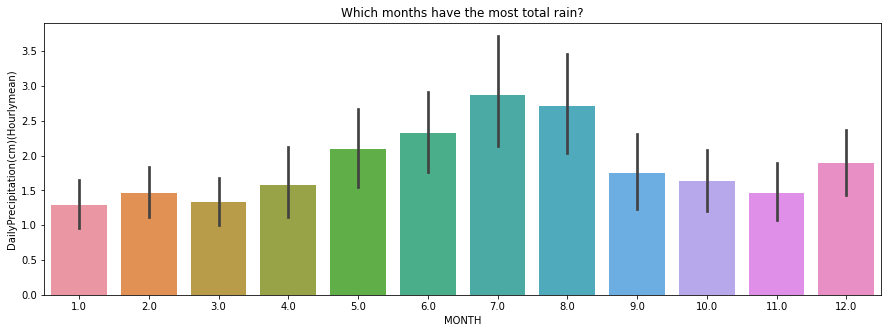

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.title("Which months have the most total rain?")
sns.barplot(data=df_weather, x='MONTH', y='DailyPrecipitation(cm)(Hourlymean)')

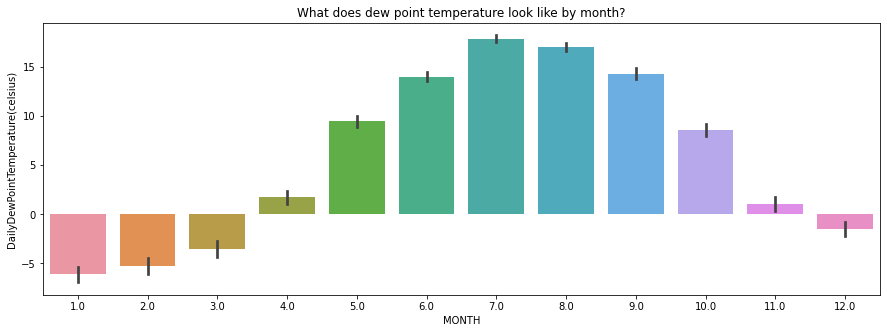

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.title("What does dew point temperature look like by month?")
sns.barplot(data=df_weather, x='MONTH', y='DailyDewPointTemperature(celsius)')

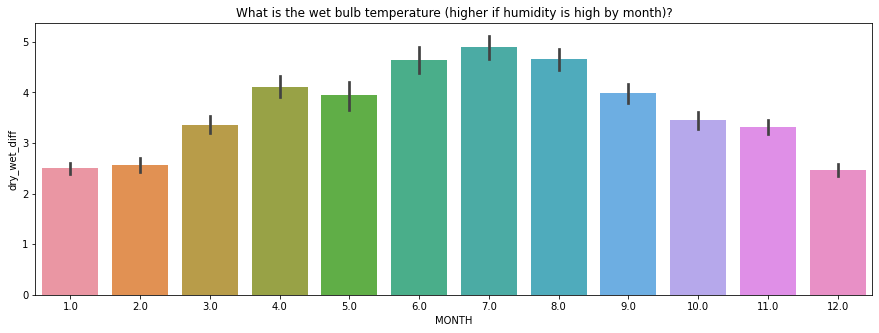

In [ ]:
df_weather_temp = df_weather
df_weather_temp['dry_wet_diff'] = df_weather['DailyDryBulbTemperature(celsius)'] - df_weather['DailyWetBulbTemperature(celsius)']

fig = plt.figure(figsize=(15,5))
plt.title("What is the wet bulb temperature (higher if humidity is high by month)?")
sns.barplot(data=df_weather_temp, x='MONTH', y='dry_wet_diff')

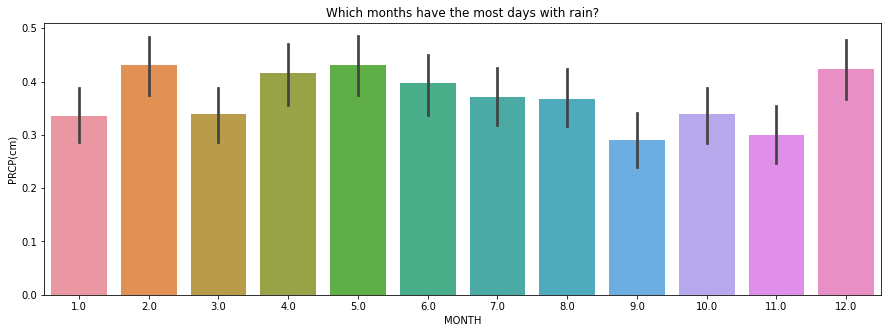

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.title("Which months have the most days with rain?")
sns.barplot(data=df_weather, x='MONTH', y='PRCP(cm)')

In [ ]:
df_weather = df_weather.reindex(columns=['YEAR', 'MONTH', 'DAY', 'AWND(metres/sec)', 'PRCP(cm)',
       'SNOW(cm)', 'SNWD(cm)', 'TMAX(celsius)', 'TMIN(celsius)',
       'WDF2(degrees)', 'WDF5(degrees)', 'WSF2(metres/sec)',
       'WSF5(metres/sec)', 'DailyDewPointTemperature(celsius)',
       'DailyDryBulbTemperature(celsius)',
       'DailyPrecipitation(cm)(Hourlymean)', 'DailyRelativeHumidity',
       'DailySeaLevelPressure(inches)', 'DailyStationPressure(inches)',
       'DailyVisibility', 'DailyWetBulbTemperature(celsius)',
       'DailyWindSpeed(miles/hr)'])

# lag data by 1 week
lagged = df_weather.shift(periods=1)
lagged = lagged.rename(columns={'YEAR': 'YEAR_lag1',
                                'MONTH': 'MONTH_lag1',
                                'DAY': 'DAY_lag1',
                                'AWND(metres/sec)': 'AWND(metres/sec)_lag1',
                                'PRCP(cm)': 'PRCP(cm)_lag1',
                                'SNOW(cm)': 'SNOW(cm)_lag1',
                                'SNWD(cm)': 'SNWD(cm)_lag1',
                                'TMAX(celsius)': 'TMAX(celsius)_lag1',
                                'TMIN(celsius)': 'TMIN(celsius)_lag1',
                                'WDF2(degrees)': 'WDF2(degrees)_lag1',
                                'WDF5(degrees)': 'WDF5(degrees)_lag1',
                                'WSF2(metres/sec)': 'WSF2(metres/sec)_lag1',
                                'WSF5(metres/sec)': 'WSF5(metres/sec)_lag1',
                                'DailyDewPointTemperature(celsius)': 'DailyDewPointTemperature(celsius)_lag1',
                                'DailyDryBulbTemperature(celsius)': 'DailyDryBulbTemperature(celsius)_lag1',
                                'DailyPrecipitation(cm)(Hourlymean)': 'DailyPrecipitation(cm)(Hourlymean)_lag1',
                                'DailyRelativeHumidity': 'DailyRelativeHumidity_lag1',
                                'DailySeaLevelPressure(inches)': 'DailySeaLevelPressure(inches)_lag1',
                                'DailyStationPressure(inches)': 'DailyStationPressure(inches)_lag1',
                                'DailyVisibility': 'DailyVisibility_lag1',
                                'DailyWetBulbTemperature(celsius)': 'DailyWetBulbTemperature(celsius)_lag1',
                                'DailyWindSpeed(miles/hr)': 'DailyWindSpeed(miles/hr)_lag1'})

#lagged.drop(columns='DATE', inplace=True)
df_weather = pd.merge(df_weather, lagged, left_index=True, right_index=True)

df_weather = df_weather.drop(columns=['YEAR', 'MONTH', 'DAY', 'AWND(metres/sec)',
       'SNOW(cm)', 'SNWD(cm)', 'TMAX(celsius)', 'TMIN(celsius)',
       'WDF2(degrees)', 'WDF5(degrees)', 'WSF2(metres/sec)',
       'WSF5(metres/sec)', 'DailyDewPointTemperature(celsius)',
       'DailyDryBulbTemperature(celsius)',
       'DailyPrecipitation(cm)(Hourlymean)', 'DailyRelativeHumidity',
       'DailySeaLevelPressure(inches)', 'DailyStationPressure(inches)',
       'DailyVisibility', 'DailyWetBulbTemperature(celsius)',
       'DailyWindSpeed(miles/hr)'])
df_weather

,PRCP(cm),YEAR_lag1,MONTH_lag1,DAY_lag1,AWND(metres/sec)_lag1,PRCP(cm)_lag1,SNOW(cm)_lag1,SNWD(cm)_lag1,TMAX(celsius)_lag1,TMIN(celsius)_lag1,WDF2(degrees)_lag1,WDF5(degrees)_lag1,WSF2(metres/sec)_lag1,WSF5(metres/sec)_lag1,DailyDewPointTemperature(celsius)_lag1,DailyDryBulbTemperature(celsius)_lag1,DailyPrecipitation(cm)(Hourlymean)_lag1,DailyRelativeHumidity_lag1,DailySeaLevelPressure(inches)_lag1,DailyStationPressure(inches)_lag1,DailyVisibility_lag1,DailyWetBulbTemperature(celsius)_lag1,DailyWindSpeed(miles/hr)_lag1
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,2011.0,5.0,2.0,2.80,0.0,0.0,0.0,16.65,10.00,150.0,165.0,5.85,8.30,6.471193,12.453704,0.000000,68.027778,30.221574,30.138621,9.993333,9.779693,6.472222
2,1.0,2011.0,5.0,3.0,3.60,0.0,0.0,0.0,22.80,11.95,275.0,215.0,7.15,9.80,10.305305,14.671717,0.000000,76.054545,30.069619,29.962545,9.831892,13.343434,8.954955
3,0.0,2011.0,5.0,4.0,3.85,1.0,0.0,0.0,17.50,8.05,300.0,305.0,8.05,10.95,9.202509,11.645646,7.717692,85.686486,29.954112,29.865938,7.322043,10.028935,9.274194
4,0.0,2011.0,5.0,5.0,5.25,0.0,0.0,0.0,17.75,8.05,290.0,310.0,10.70,14.30,1.293019,12.227096,0.338667,52.884956,29.922075,29.860833,9.634386,7.024482,11.842105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,1.0,2021.0,4.0,15.0,3.25,1.0,0.0,0.0,14.70,7.20,325.0,295.0,7.85,11.40,8.237179,10.929487,9.786471,83.875000,29.721786,29.633269,6.639904,9.556624,6.851485
3638,0.0,2021.0,4.0,16.0,4.40,1.0,0.0,0.0,11.70,5.30,255.0,255.0,9.20,14.10,2.129630,7.793210,0.390769,68.736111,29.651250,29.571528,9.743333,5.246914,9.333333
3639,0.0,2021.0,4.0,17.0,3.15,0.0,0.0,0.0,13.05,6.40,275.0,275.0,6.25,8.75,1.345486,9.487847,0.000000,58.609375,29.765714,29.675937,9.992500,5.824653,7.063492
3640,0.0,2021.0,4.0,18.0,2.50,0.0,0.0,0.0,17.50,9.70,200.0,205.0,5.60,7.85,2.609127,13.095238,0.000000,50.196429,29.822679,29.744643,9.991429,8.154762,5.803571


In [ ]:
df_weather = df_weather.drop([0])
df_weather.tail(14)

,PRCP(cm),YEAR_lag1,MONTH_lag1,DAY_lag1,AWND(metres/sec)_lag1,PRCP(cm)_lag1,SNOW(cm)_lag1,SNWD(cm)_lag1,TMAX(celsius)_lag1,TMIN(celsius)_lag1,WDF2(degrees)_lag1,WDF5(degrees)_lag1,WSF2(metres/sec)_lag1,WSF5(metres/sec)_lag1,DailyDewPointTemperature(celsius)_lag1,DailyDryBulbTemperature(celsius)_lag1,DailyPrecipitation(cm)(Hourlymean)_lag1,DailyRelativeHumidity_lag1,DailySeaLevelPressure(inches)_lag1,DailyStationPressure(inches)_lag1,DailyVisibility_lag1,DailyWetBulbTemperature(celsius)_lag1,DailyWindSpeed(miles/hr)_lag1
3628,0.0,2021.0,4.0,6.0,3.35,0.0,0.0,0.0,20.85,8.85,280.0,280.0,8.05,10.70,-6.835317,14.315476,0.000000,25.446429,29.931923,29.855179,9.991429,5.853175,8.585366
3629,0.0,2021.0,4.0,7.0,1.95,0.0,0.0,0.0,21.95,10.60,130.0,115.0,6.05,7.65,0.327381,14.007937,0.000000,39.464286,29.990536,29.913636,9.991429,7.708333,4.851852
3630,1.0,2021.0,4.0,8.0,2.20,0.0,0.0,0.0,21.10,9.15,125.0,140.0,6.70,9.15,4.503968,14.285714,0.000000,53.696429,30.092679,30.015000,9.991429,9.454365,5.000000
3631,1.0,2021.0,4.0,9.0,2.35,1.0,0.0,0.0,14.70,9.15,130.0,135.0,5.60,7.60,6.430976,10.757576,0.052917,75.242424,30.148393,30.071970,9.947273,8.754209,5.712121
3632,1.0,2021.0,4.0,10.0,2.15,1.0,0.0,0.0,20.25,10.30,140.0,150.0,5.60,7.65,9.665145,14.117199,0.052917,75.616438,29.945000,29.872329,8.726986,11.735160,4.753425
3633,1.0,2021.0,4.0,11.0,4.15,1.0,0.0,0.0,13.60,8.30,215.0,40.0,9.35,13.20,10.465608,11.661376,4.884615,92.304762,29.643393,29.540762,2.389714,10.989418,9.047619
3634,1.0,2021.0,4.0,12.0,3.85,1.0,0.0,0.0,10.60,7.50,210.0,200.0,9.35,14.10,5.368481,8.458050,5.526216,81.724490,29.799821,29.727449,7.232347,7.091837,8.346939
3635,0.0,2021.0,4.0,13.0,2.65,1.0,0.0,0.0,18.30,6.95,110.0,325.0,6.30,8.05,4.017094,11.427350,0.877455,63.492308,30.023571,29.930769,9.865846,7.931624,5.861538
3636,1.0,2021.0,4.0,14.0,2.35,0.0,0.0,0.0,22.20,9.15,215.0,210.0,6.70,9.35,6.704981,15.478927,0.000000,59.068966,29.971964,29.888966,9.991724,10.986590,5.921569
3637,1.0,2021.0,4.0,15.0,3.25,1.0,0.0,0.0,14.70,7.20,325.0,295.0,7.85,11.40,8.237179,10.929487,9.786471,83.875000,29.721786,29.633269,6.639904,9.556624,6.851485


In [ ]:
train_val_df = df_weather[:-1]

test_data = df_weather[-1:]

train_data, val_data = train_test_split(train_val_df, test_size = 0.3, random_state = 123)

In [ ]:
x_train = train_data.drop(columns=['PRCP(cm)'])
x_train

,YEAR_lag1,MONTH_lag1,DAY_lag1,AWND(metres/sec)_lag1,PRCP(cm)_lag1,SNOW(cm)_lag1,SNWD(cm)_lag1,TMAX(celsius)_lag1,TMIN(celsius)_lag1,WDF2(degrees)_lag1,WDF5(degrees)_lag1,WSF2(metres/sec)_lag1,WSF5(metres/sec)_lag1,DailyDewPointTemperature(celsius)_lag1,DailyDryBulbTemperature(celsius)_lag1,DailyPrecipitation(cm)(Hourlymean)_lag1,DailyRelativeHumidity_lag1,DailySeaLevelPressure(inches)_lag1,DailyStationPressure(inches)_lag1,DailyVisibility_lag1,DailyWetBulbTemperature(celsius)_lag1,DailyWindSpeed(miles/hr)_lag1
1697,2015.0,12.0,23.0,2.60,1.0,0.0,0.0,17.50,10.55,175.0,170.0,6.30,8.95,11.546296,13.101852,24.717204,90.641667,30.068571,29.961417,2.294917,12.199074,6.325000
1401,2015.0,3.0,2.0,5.10,0.0,0.0,26.5,3.60,-2.40,310.0,310.0,11.00,16.55,-7.450980,0.343137,0.000000,59.147059,30.153929,30.059706,8.684706,-2.238562,10.863636
3562,2021.0,1.0,30.0,4.75,0.0,0.0,0.0,0.55,-7.65,325.0,310.0,8.05,11.60,-14.801587,-3.878968,0.000000,43.964286,30.271429,30.189815,9.991429,-6.759259,11.129630
1583,2015.0,8.0,31.0,3.10,0.0,0.0,0.0,33.05,24.70,255.0,250.0,6.95,10.95,18.432540,28.591270,0.000000,55.375000,29.990000,29.913393,9.527143,21.875000,7.272727
1108,2014.0,5.0,13.0,3.95,0.0,0.0,0.0,22.25,11.40,50.0,65.0,9.15,12.05,7.592593,17.046296,0.000000,55.566667,30.183929,30.101167,9.825333,12.194444,9.116667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,2014.0,5.0,28.0,4.70,0.0,0.0,0.0,16.70,11.95,60.0,70.0,8.50,10.70,10.016340,14.076797,0.000000,76.897059,29.993036,29.902647,9.713529,11.903595,10.867647
1347,2015.0,1.0,7.0,7.30,0.0,0.0,3.0,-4.35,-12.40,310.0,300.0,12.95,19.00,-16.034483,-7.183908,0.000000,50.672414,30.037679,29.957759,9.681379,-9.157088,17.035714
3455,2020.0,10.0,15.0,3.65,0.0,0.0,0.0,22.25,14.15,175.0,185.0,8.50,12.95,12.172619,18.204365,0.000000,68.482143,29.983929,29.905893,9.991429,14.751984,8.962264
3438,2020.0,9.0,28.0,3.30,1.0,0.0,0.0,25.55,20.85,150.0,180.0,6.45,8.75,18.888889,22.329060,0.304800,81.589744,29.897857,29.814615,9.205769,20.135328,7.342105


In [ ]:
x_val = val_data.drop(columns=['PRCP(cm)'])
x_val

,YEAR_lag1,MONTH_lag1,DAY_lag1,AWND(metres/sec)_lag1,PRCP(cm)_lag1,SNOW(cm)_lag1,SNWD(cm)_lag1,TMAX(celsius)_lag1,TMIN(celsius)_lag1,WDF2(degrees)_lag1,WDF5(degrees)_lag1,WSF2(metres/sec)_lag1,WSF5(metres/sec)_lag1,DailyDewPointTemperature(celsius)_lag1,DailyDryBulbTemperature(celsius)_lag1,DailyPrecipitation(cm)(Hourlymean)_lag1,DailyRelativeHumidity_lag1,DailySeaLevelPressure(inches)_lag1,DailyStationPressure(inches)_lag1,DailyVisibility_lag1,DailyWetBulbTemperature(celsius)_lag1,DailyWindSpeed(miles/hr)_lag1
2349,2017.0,10.0,5.0,3.40,0.0,0.0,0.0,28.60,18.60,260.0,245.0,7.60,10.75,15.575397,23.174603,0.000000,63.535714,30.088036,30.010000,9.920000,18.472222,8.240741
3047,2019.0,9.0,3.0,2.65,0.0,0.0,0.0,27.80,20.00,105.0,100.0,5.35,7.60,15.584795,23.362573,0.000000,63.596491,30.017679,29.940000,9.974035,18.606238,6.363636
968,2013.0,12.0,24.0,4.95,0.0,0.0,0.0,5.60,-2.95,315.0,315.0,10.30,14.55,-6.884921,2.043651,0.000000,52.321429,30.172182,30.092679,9.991429,-1.051587,11.471698
478,2012.0,8.0,21.0,2.15,0.0,0.0,0.0,28.05,19.75,165.0,185.0,4.50,8.30,14.512671,23.538012,0.000000,58.280702,30.017857,29.938772,9.991579,18.089669,5.105263
958,2013.0,12.0,14.0,6.05,1.0,12.3,0.0,1.65,-4.90,65.0,65.0,11.20,14.35,-5.990741,-2.796296,5.597864,79.891667,30.306071,30.187083,2.794000,-3.842593,14.775000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,2013.0,1.0,1.0,5.00,0.0,0.0,0.0,4.70,-3.05,285.0,310.0,8.70,13.60,-5.575049,2.709552,0.000000,55.105263,29.898214,29.818596,9.934737,-0.243665,11.892857
2381,2017.0,11.0,6.0,3.60,1.0,0.0,0.0,18.90,8.35,310.0,295.0,8.25,11.65,12.595029,15.752924,0.052917,81.986842,29.959474,29.879867,9.480526,14.022222,8.388889
1770,2016.0,3.0,5.0,2.85,0.0,0.0,0.0,5.00,-1.55,350.0,355.0,6.70,8.95,-10.188492,1.398810,0.000000,43.642857,30.167143,30.086786,9.991429,-2.242063,6.785714
222,2011.0,12.0,9.0,3.05,0.0,0.0,0.0,11.40,2.20,220.0,180.0,6.50,9.15,0.906433,7.153996,0.000000,65.368421,30.285926,30.195000,9.905965,4.130824,7.166667


In [ ]:
y_train = train_data['PRCP(cm)']
y_val = val_data['PRCP(cm)']

In [ ]:
# get counts of the label
y_train.value_counts()

0.0    1620
1.0     928
Name: PRCP(cm), dtype: int64

In [ ]:
# what's the ratio of each label category in the training set?
y_train.value_counts() / y_train.value_counts().sum()

0.0    0.635793
1.0    0.364207
Name: PRCP(cm), dtype: float64

In [ ]:
# standardize the columns in the training and validation datasets
for field in x_train.columns:
    standard_dev = x_train[field].std()
    mean = x_train[field].mean()
    
    x_train[field] = (x_train[field] - mean) / standard_dev
    x_val[field] = (x_val[field] - mean) / standard_dev

In [ ]:
logit_model = LogisticRegression(random_state=0, C = 1.0 , penalty = "l1", solver = "liblinear").fit(x_train, y_train)

# validation set AUC score for different parameter values:
# 1.5  - 0.6537418953725909
# 1.0  - 0.6538449240607513
# 0.5  - 0.6537845279332091
# 0.25 - 0.653361755040412
# .1   - 0.650565769606537
# .01. - 0.6331610267341682

In [ ]:
logit_model.predict_proba(x_train)

array([[0.50666972, 0.49333028],
       [0.72151945, 0.27848055],
       [0.72881136, 0.27118864],
       ...,
       [0.66288369, 0.33711631],
       [0.45366436, 0.54633564],
       [0.69188594, 0.30811406]])

In [ ]:
y_train_pred = logit_model.predict(x_train)
y_train_pred

array([0., 0., 0., ..., 0., 1., 0.])

In [ ]:
y_val_pred = logit_model.predict(x_val)
y_val_pred

array([0., 0., 0., ..., 0., 0., 0.])

### Calculate Evaluation Metrics

In [ ]:
# calculate accuracy
metrics.accuracy_score(y_train, y_train_pred)

0.6781789638932496

In [ ]:
metrics.accuracy_score(y_val, y_val_pred)

0.6401098901098901

In [ ]:
# precision
metrics.precision_score(y_train, y_train_pred)

0.610655737704918

In [ ]:
metrics.precision_score(y_val, y_val_pred)

0.5566037735849056

In [ ]:
# recall
metrics.recall_score(y_train, y_train_pred)

0.32112068965517243

In [ ]:
metrics.recall_score(y_val, y_val_pred)

0.2829736211031175

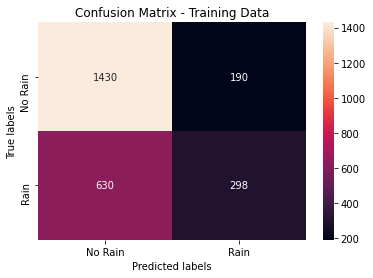

In [ ]:
cm = metrics.confusion_matrix(y_train, y_train_pred)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Training Data'); 
ax.xaxis.set_ticklabels(['No Rain', 'Rain']);
ax.yaxis.set_ticklabels(['No Rain', 'Rain']);

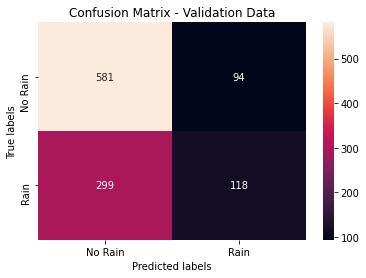

In [ ]:
cm = metrics.confusion_matrix(y_val, y_val_pred)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Validation Data'); 
ax.xaxis.set_ticklabels(['No Rain', 'Rain']);
ax.yaxis.set_ticklabels(['No Rain', 'Rain']);

In [ ]:
# f1-score
metrics.f1_score(y_train, y_train_pred)

0.42090395480225995

In [ ]:
metrics.f1_score(y_val, y_val_pred)

0.3751987281399046

In [ ]:
# AUC
y_train_prob = logit_model.predict_proba(x_train)
y_val_prob = logit_model.predict_proba(x_val)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)

metrics.auc(fpr, tpr)

0.6741485738612176

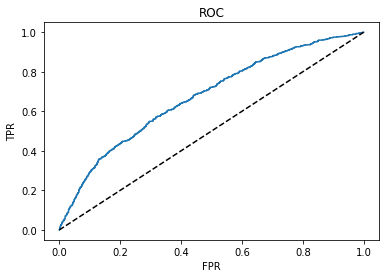

In [ ]:
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], color = 'black', linestyle = "dashed")
plt.title("ROC")
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_prob[:,1], pos_label = 1)
metrics.auc(fpr, tpr)

0.6538449240607513

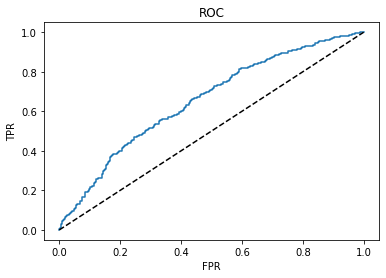

In [ ]:
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], color = 'black', linestyle = "dashed")
plt.title("ROC")
plt.show()

In [ ]:
# If today is 4/20, this is yesterday's data:
x_test = test_data.drop(columns=['PRCP(cm)'])
x_test

,YEAR_lag1,MONTH_lag1,DAY_lag1,AWND(metres/sec)_lag1,PRCP(cm)_lag1,SNOW(cm)_lag1,SNWD(cm)_lag1,TMAX(celsius)_lag1,TMIN(celsius)_lag1,WDF2(degrees)_lag1,WDF5(degrees)_lag1,WSF2(metres/sec)_lag1,WSF5(metres/sec)_lag1,DailyDewPointTemperature(celsius)_lag1,DailyDryBulbTemperature(celsius)_lag1,DailyPrecipitation(cm)(Hourlymean)_lag1,DailyRelativeHumidity_lag1,DailySeaLevelPressure(inches)_lag1,DailyStationPressure(inches)_lag1,DailyVisibility_lag1,DailyWetBulbTemperature(celsius)_lag1,DailyWindSpeed(miles/hr)_lag1
3641,2021.0,4.0,19.0,1.95,0.0,0.0,0.0,18.3,11.1,135.0,185.0,6.5,8.95,3.363095,14.751984,0.0,47.303571,29.837679,29.759286,9.991429,9.255952,4.607143


In [ ]:
# Will it rain on 4/20/21?
logit_model.predict_proba(x_test)

array([[0., 1.]])

In [ ]:
parameters = {"max_depth":range(2, 8), "min_samples_leaf": range(5, 55, 5), "min_samples_split": range(10, 110, 5)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1, scoring = "roc_auc")
clf.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(2, 8),
                         '

In [ ]:
# look at the best parameters
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
## Create a data frame with the feature importances
###################################################
# First create an empty data frame
imp = pd.DataFrame()

# add a column for the variable names
imp["var"] = x_train.columns

# add a column with the feature importances
imp["imp"] = clf.best_estimator_.feature_importances_

# sort the data frame by the feature importances in descending order - most important features at the top
imp = imp.sort_values("imp", ascending = False).reset_index(drop = True)

# print out the data frame
imp

,var,imp
0,WDF2(degrees)_lag1,0.265602
1,DailyPrecipitation(cm)(Hourlymean)_lag1,0.204264
2,DailyWindSpeed(miles/hr)_lag1,0.115702
3,DailySeaLevelPressure(inches)_lag1,0.081007
4,WSF5(metres/sec)_lag1,0.075744
5,DailyDewPointTemperature(celsius)_lag1,0.052956
6,DailyRelativeHumidity_lag1,0.047946
7,DailyVisibility_lag1,0.046906
8,AWND(metres/sec)_lag1,0.041618
9,DailyDryBulbTemperature(celsius)_lag1,0.040450


In [ ]:
# Get the predicted probabilities on the training set
y_train_prob = clf.predict_proba(x_train)
y_train_prob

array([[0.39759036, 0.60240964],
       [0.85227273, 0.14772727],
       [0.8625    , 0.1375    ],
       ...,
       [0.67213115, 0.32786885],
       [0.30952381, 0.69047619],
       [0.8625    , 0.1375    ]])

In [ ]:
# Get the validation probabilities
y_val_prob = clf.predict_proba(x_val)
y_val_prob

array([[0.83870968, 0.16129032],
       [0.89361702, 0.10638298],
       [0.8625    , 0.1375    ],
       ...,
       [0.7       , 0.3       ],
       [0.30188679, 0.69811321],
       [0.61643836, 0.38356164]])

In [ ]:
# calculate AUC on the training set using the optimized decision tree model
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
metrics.auc(fpr, tpr)

0.7540875106428266

In [ ]:
# Note that the AUC is several percentage points higher than previously, though we still have some problems
# with overfitting since the validation AUC is several points lower than the training AUC
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_prob[:,1], pos_label = 1)
metrics.auc(fpr, tpr)

0.6497681854516387

In [ ]:
# Will it rain on 4/20/21?
clf.predict_proba(x_test)

array([[1., 0.]])